In [11]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import matplotlib as mpl
import seaborn as sns

import utils as utl
from pathlib import Path

from scipy.ndimage import gaussian_filter1d

filter_stim = lambda df : df.loc[ (df.loc[:, 'fnum'] % 1400 >= 400) & (df.loc[:, 'fnum'] % 1400 < 1000) ].copy()

filter_frames = lambda df, f_0, f_f: df.loc[ ((df.loc[:, 'fnum'] % 1400) >= f_0) & ((df.loc[:, 'fnum'] % 1400) < f_f) ]

norm = lambda x: x / np.linalg.norm(x)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Raw Data

In [51]:
# load HDF file
data = utl.load_data_hdf('./config.yml')

INFO: loading file data\Ballsystem_LegKinematics_DataStructures\P9_BPN\alldata_V6.h5
INFO: found genotype BPN
INFO: Renaming stepcycle columns
INFO: found genotype P9LT
INFO: Renaming stepcycle columns
INFO: found genotype P9RT
INFO: Renaming stepcycle columns


# Fly-centric coord system

In [122]:


def fit_plane_thc(df):


    df = df.copy()

    cols = [c for c in df.columns if c[-5:] in [ 'ThC_x', 'ThC_y', 'ThC_z'] ]

    xs, ys, zs = [], [], []
    for x, y, z in zip(cols[::3], cols[1::3], cols[2::3]):
        xs.extend(df.loc[:, x])    
        ys.extend(df.loc[:, y])
        zs.extend(df.loc[:, z])

    A = np.vstack([xs, ys, np.ones(len(xs), )]).T
    b = np.array(zs)
    res = np.linalg.lstsq(A, b, rcond=None)

    a, b, c = res[0]
    print('INFO: Fitted plane through ThC points')
    print('      a = {:1.2f}, b = {:1.2f}, c = {:1.2f}, residual = {:1.1f}'.format(a, b, c, res[1].item()))

    return a, b, c


def construct_basis(df, a, b, c):

    norm = lambda x: x / np.linalg.norm(x)

    # intermediate basis (necessary to project points on ThC plane)
    n = norm(np.array([-a, -b, 1]))
    o = np.array([0, 0, c])
    e1 = norm(np.array([1, 0, a]))
    e2 = np.cross(e1, n)

    # mean of points used for final basis
    cols = [ 'Notum_{}'.format(i) for i in 'xyz' ]
    notum = df.loc[:, cols].mean().values
    cols = [ 'R-WH_{}'.format(i) for i in 'xyz' ]
    rwh = df.loc[:, cols].mean().values
    cols = [ 'L-WH_{}'.format(i) for i in 'xyz' ]
    lwh = df.loc[:, cols].mean().values

    # projection of points in to intermediate basis
    proj12 = lambda p: o + np.dot(p - o, e1) * e1 + np.dot(p - o, e2) * e2

    # z axis normal to the mean ThC points, positive towards notum
    ez = n if np.dot(n, notum - o) > 0 else -n 
    # x axis along WH (R-WH) positive
    ex = norm(proj12(rwh) - proj12(lwh))
    # y axis perpendicular to WH connection, positive towards head
    ey = np.cross(ez, ex)

    # construct transformation matrixn
    T = np.vstack([ex, ey, ez]).T

    # center is mean of WH
    center = np.mean([proj12(rwh), proj12(lwh)], axis=0) 

    return T, center

def plot_coord_system(df, joints=['WH', 'ThC', 'Notum'], return_lims=False, lims=(), marker='o', marker_size=5, swing=False, path=''):
    
    fig, axarr = plt.subplots(ncols=3, figsize=(15, 5))

    cols = [ c for c in df.columns if c[-1] in 'xyz' ]
    cols = [ c for c in cols if c.split('_')[0].split('-')[-1] in joints ]
    
    xlabel = 'x (left/right)'
    ylabel = 'y (posterior/anterior)'
    zlabel = 'z (ventral/dorsal)'

    for col_xyz in zip(cols[::3], cols[1::3], cols[2::3]):


        xyz = df.loc[:, col_xyz].values

        x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]

        leg = col_xyz[0][:3]
        if swing:
            s = df.loc[:, '{}_stepcycle'.format(leg)]
        else:
            s = np.ones(len(df)).astype(bool)

        ax = axarr[0]
        ax.scatter(y[s], z[s], marker=marker, s=marker_size, label=col_xyz[0][:-2])
        ax.scatter(y[~s], z[~s], marker=marker, s=marker_size, c='gray')
        ax.set_xlabel(ylabel)
        ax.set_ylabel(zlabel)
        ax.set_title('side view')
        ax.legend(loc='upper right')

        ax = axarr[1]
        ax.scatter(x, y, marker=marker, s=marker_size)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title('top view')

        ax = axarr[2]
        ax.scatter(x, z, marker=marker, s=marker_size)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(zlabel)
        ax.set_title('front view')
    
    for ax in axarr:
        ax.axvline(0, ls=':', c='gray')
        ax.axhline(0, ls=':', c='gray')
    
    if lims:
        for ax, x, y in zip(axarr, lims[0], lims[1]):
            ax.set_xlim(x)
            ax.set_ylim(y)
            
    if return_lims:
        xlims = [ ax.get_xlim() for ax in axarr ]
        ylims = [ ax.get_ylim() for ax in axarr ]
        plt.close(fig)
        return xlims, ylims
    
    fig.tight_layout()

    if path:
        fig.savefig(path)
        plt.close(fig)

        


def transform_to_flycentric(df):

    df = df.copy()
    
    a, b, c = fit_plane_thc(df)
    T, center = construct_basis(df, a, b, c)

    cols = [c for c in df.columns if c[-2:] in ['_x', '_y', '_z']]

    for col_xyz in zip(cols[::3], cols[1::3], cols[2::3]):

        xyz = df.loc[:, col_xyz].values
        xyz -= center
        xyz = xyz @ T

        df.loc[df.index, col_xyz] = xyz
    
    return df

df = data['P9LT'].groupby('flynum').get_group(1)
df = transform_to_flycentric(df)
df = filter_stim(df)
plot_coord_system(df, path='./plots/flycent.png')

# for gen, df_gen in data.items():
#     for flynum, df in df_gen.groupby('flynum'):

#         df = transform_to_flycentric(df)

#         df_gen.loc[df.index, df.columns] = df

#         p = Path('plots/stepcycles/{}/flynum{}'.format(gen, flynum))
#         plot_coord_system(df, path=p)

INFO: Fitted plane through ThC points
      a = -0.21, b = -9.32, c = 89.66, residual = 297.2


## Touch downs and lift offs

In [123]:

def add_step_td_lo(df):

    df = df.copy()

    cols = [c for c in df.columns if c.endswith('_stepcycle')]
    d = df.loc[:, cols].astype(int).apply(np.diff, axis=0)

    cols_td = [ '{}_stepTD'.format(c.split('_')[0]) for c in cols]
    df.loc[df.index[:-1], cols_td] = (d == +1).values

    cols_lo = [ '{}_stepLO'.format(c.split('_')[0]) for c in cols]
    df.loc[df.index[:-1], cols_lo] = (d == -1).values

    return df


def filter_step(df, event):

    df = df.copy()

    cols_event = [ c for c in df.columns if c.endswith(event) ]
    for ce in cols_event:
        leg = ce.split('_')[0]
        cols_xyz = [ c for c in df.columns if c.startswith(leg) and c[-1] in 'xyz' ]

        df.loc[df.index, cols_xyz] = df.loc[:, cols_xyz].where( df.loc[:, ce] ).values

    return df


df = data['P9LT'].groupby('flynum').get_group(1)
df = filter_stim(df)
df = transform_to_flycentric(df)
df = add_step_td_lo(df)

lims = plot_coord_system(df, joints=['TaG'], marker='.', return_lims=True)
plot_coord_system(filter_step(df, 'TD'), joints=['TaG'], marker='.', lims=lims, path='./plots/l_td.png')
plot_coord_system(filter_step(df, 'LO'), joints=['TaG'], marker='.', lims=lims, path='./plots/l_lo.png')


INFO: Fitted plane through ThC points
      a = -0.25, b = -9.28, c = 89.67, residual = 125.0


In [124]:
df = data['P9RT'].groupby('flynum').get_group(1)
df = filter_stim(df)
df = transform_to_flycentric(df)
df = add_step_td_lo(df)

lims = plot_coord_system(df, joints=['TaG'], marker='.', return_lims=True)
plot_coord_system(filter_step(df, 'TD'), joints=['TaG'], marker='.', lims=lims, path='./plots/r_td.png')
plot_coord_system(filter_step(df, 'LO'), joints=['TaG'], marker='.', lims=lims, path='./plots/r_lo.png')

INFO: Fitted plane through ThC points
      a = 0.43, b = -13.79, c = 89.24, residual = 1205.6


INFO: Fitted plane through ThC points
      a = 0.29, b = -2.25, c = 98.91, residual = 51.3


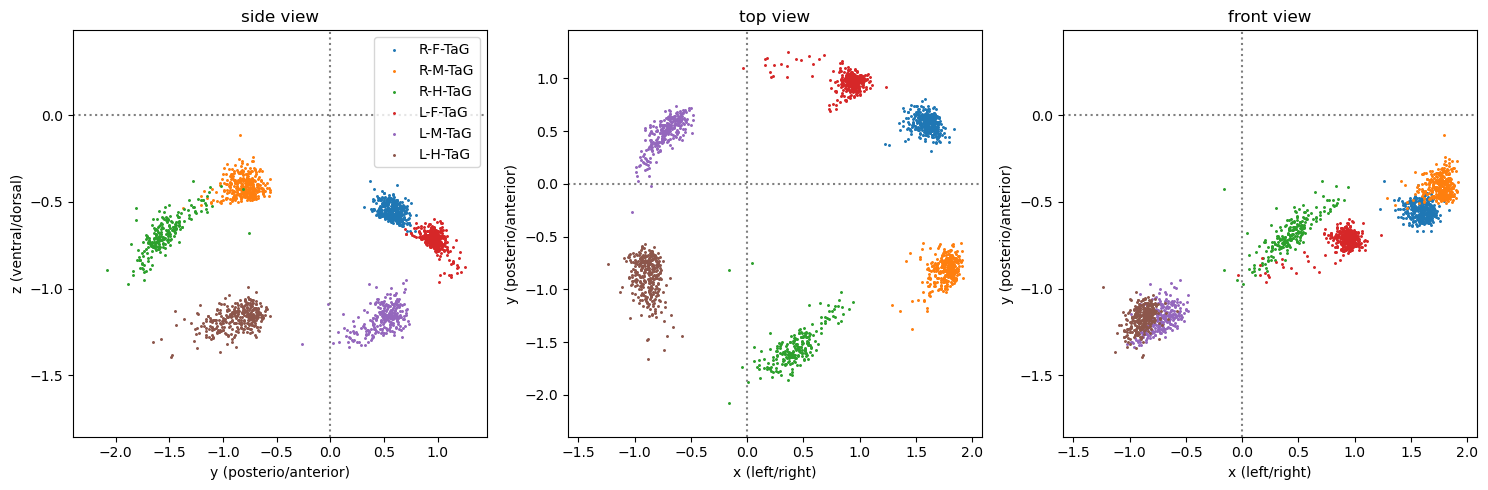

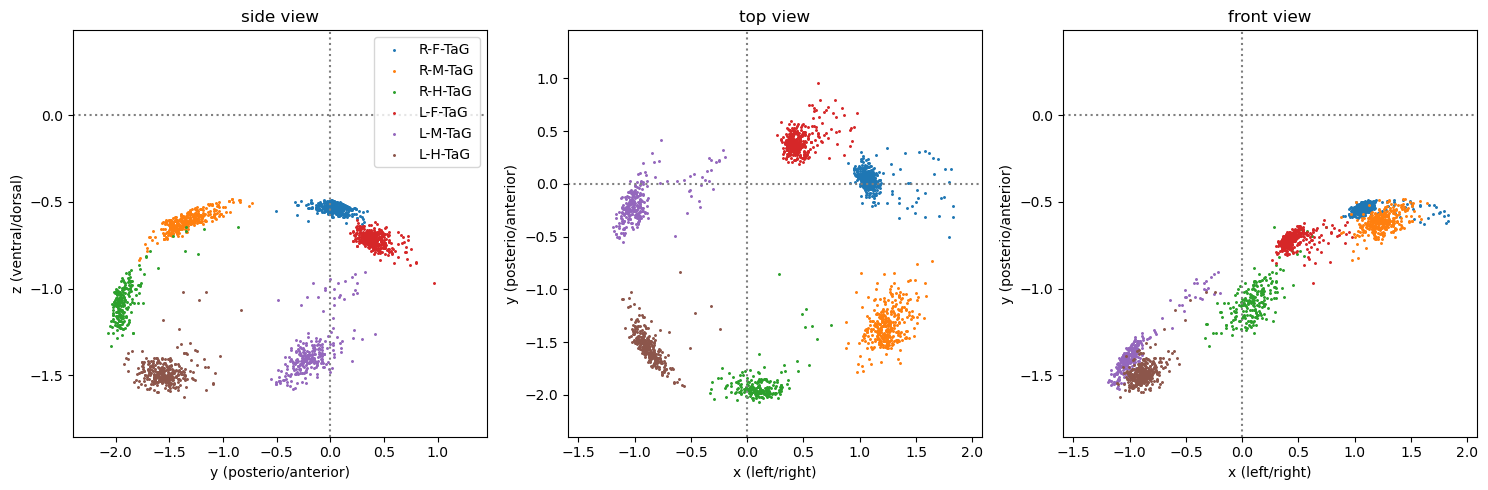

In [158]:
df = data['BPN'].groupby('flynum').get_group(1)
df = filter_stim(df)
df = transform_to_flycentric(df)
df = add_step_td_lo(df)

lims = plot_coord_system(df, joints=['TaG'], marker='.', return_lims=True)

plot_coord_system(filter_step(df, 'TD'), joints=['TaG'], marker='.', lims=lims)
plot_coord_system(filter_step(df, 'LO'), joints=['TaG'], marker='.', lims=lims)

## Time series

INFO: Fitted plane through ThC points
      a = -0.21, b = -9.32, c = 89.66, residual = 297.2


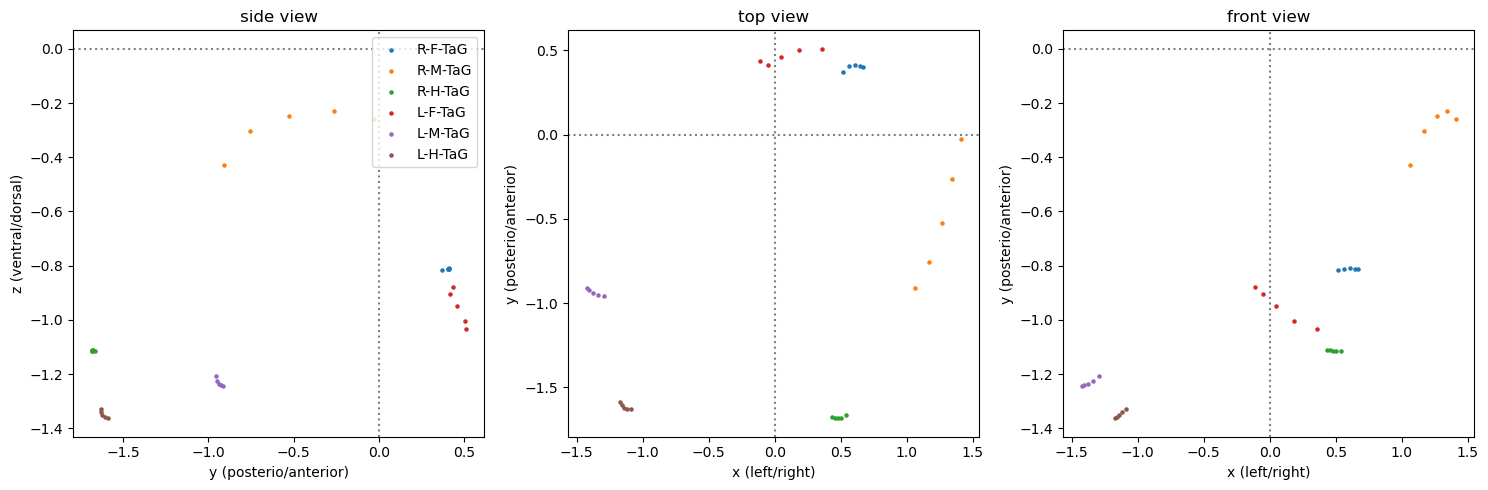

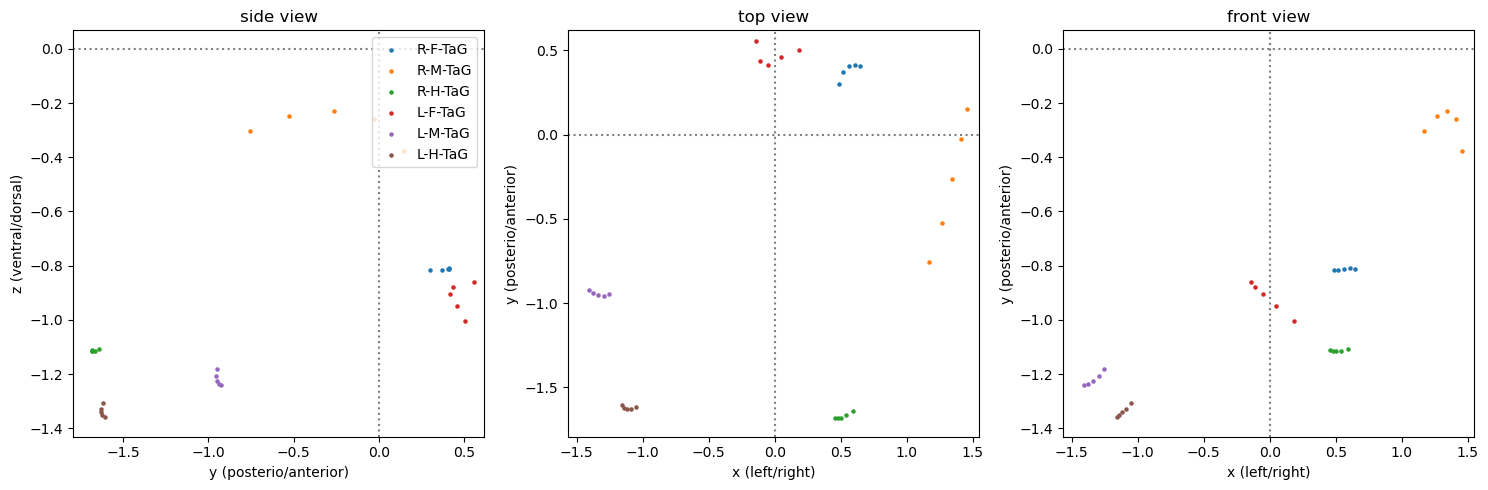

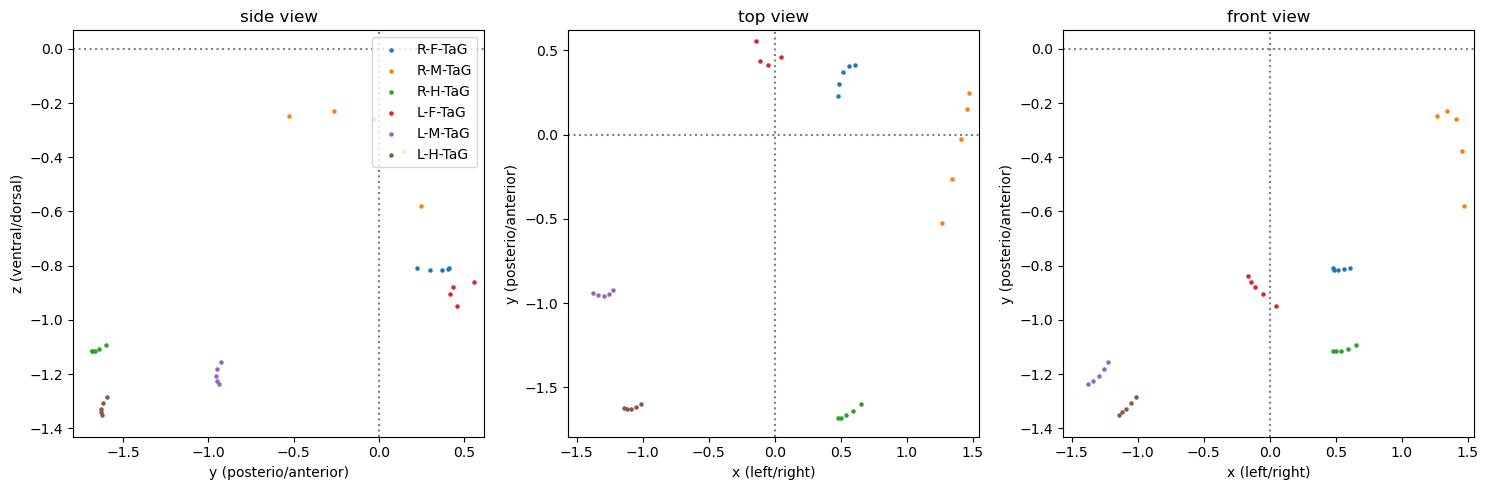

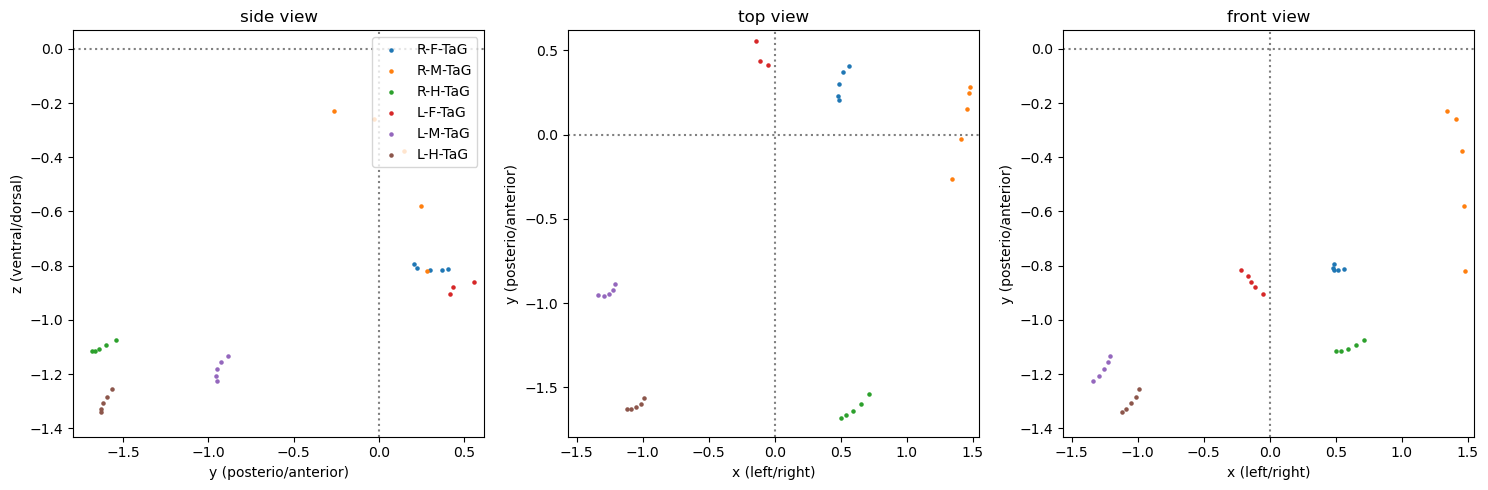

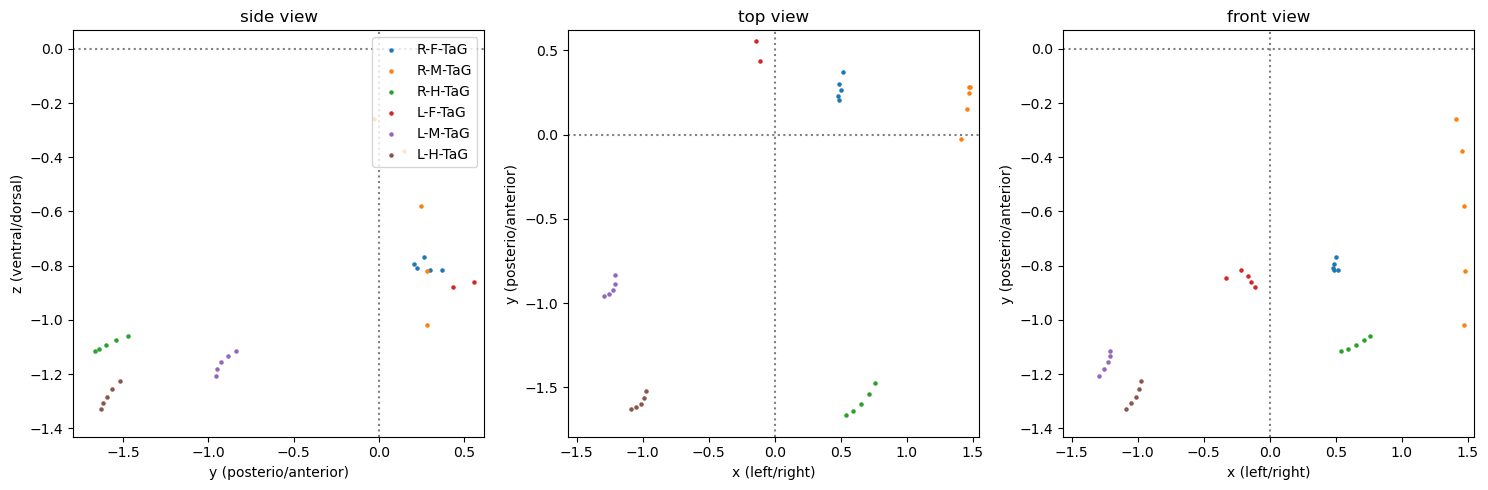

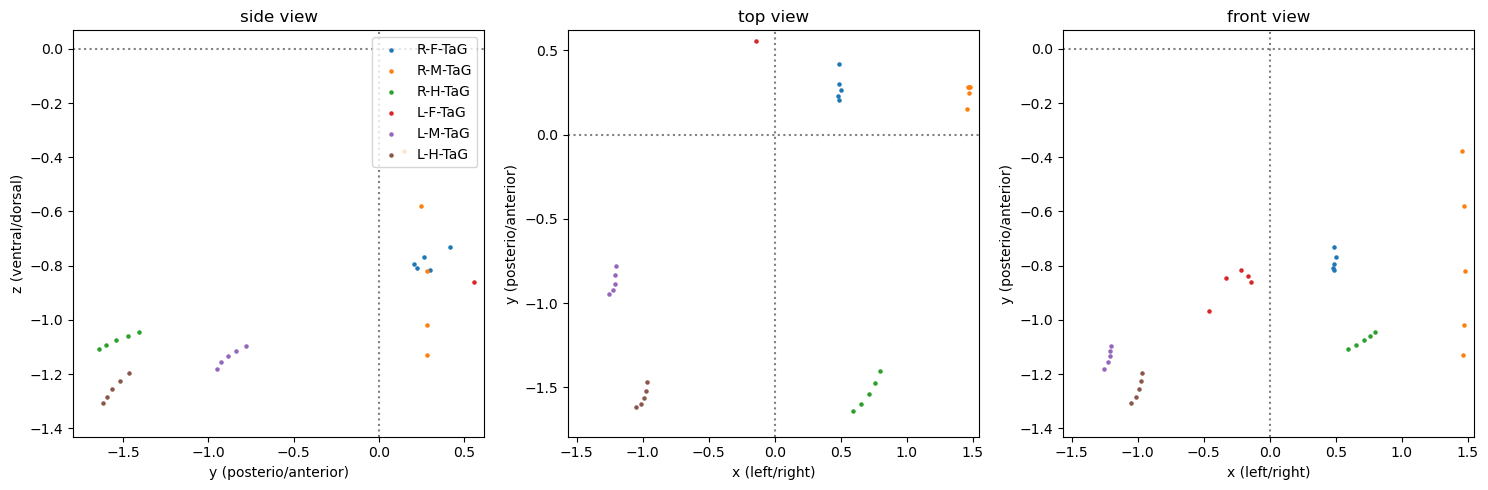

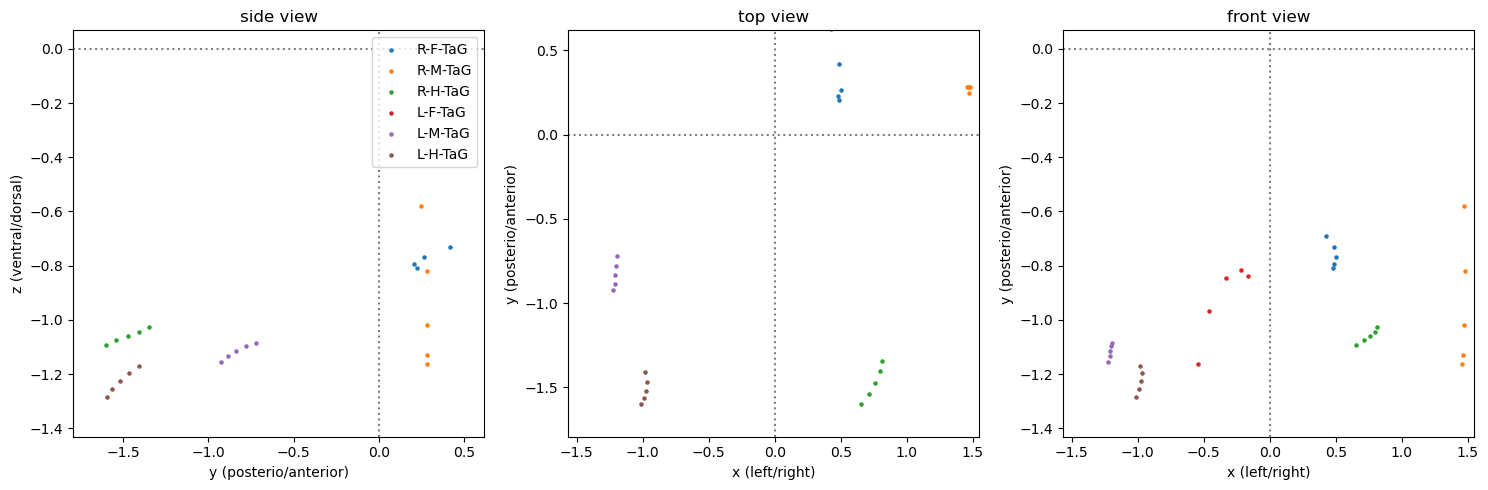

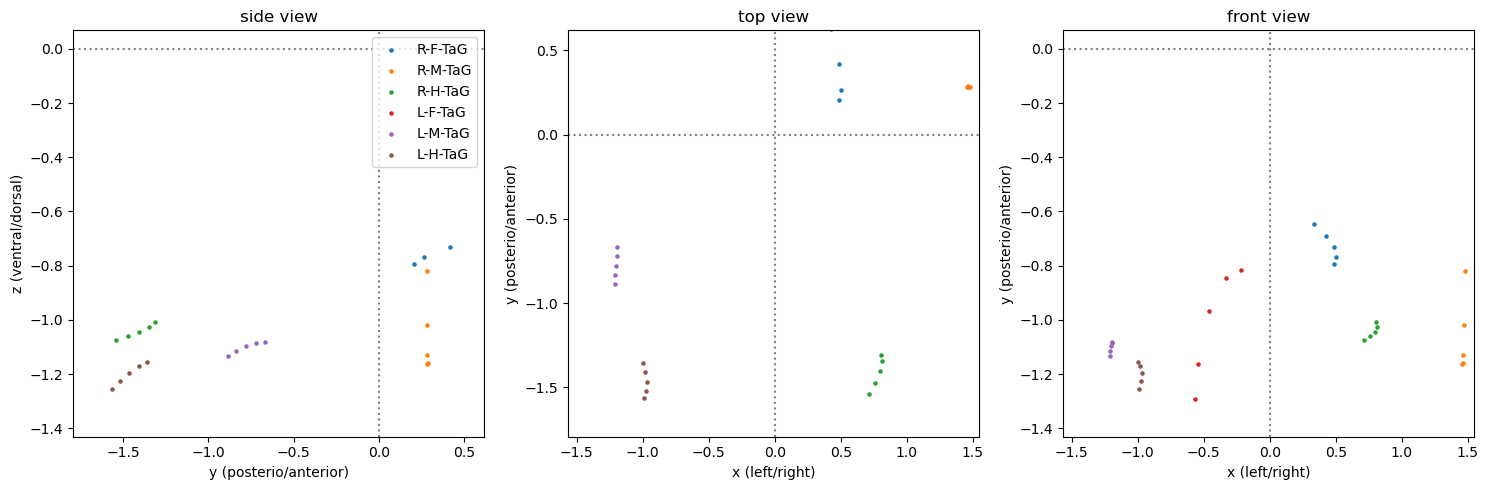

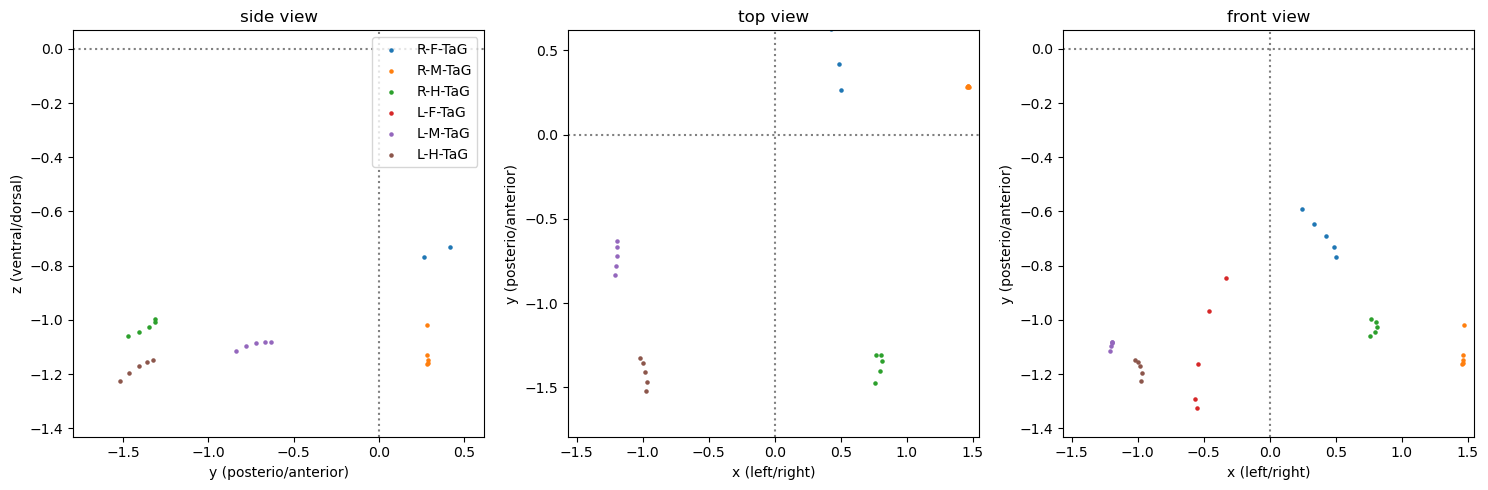

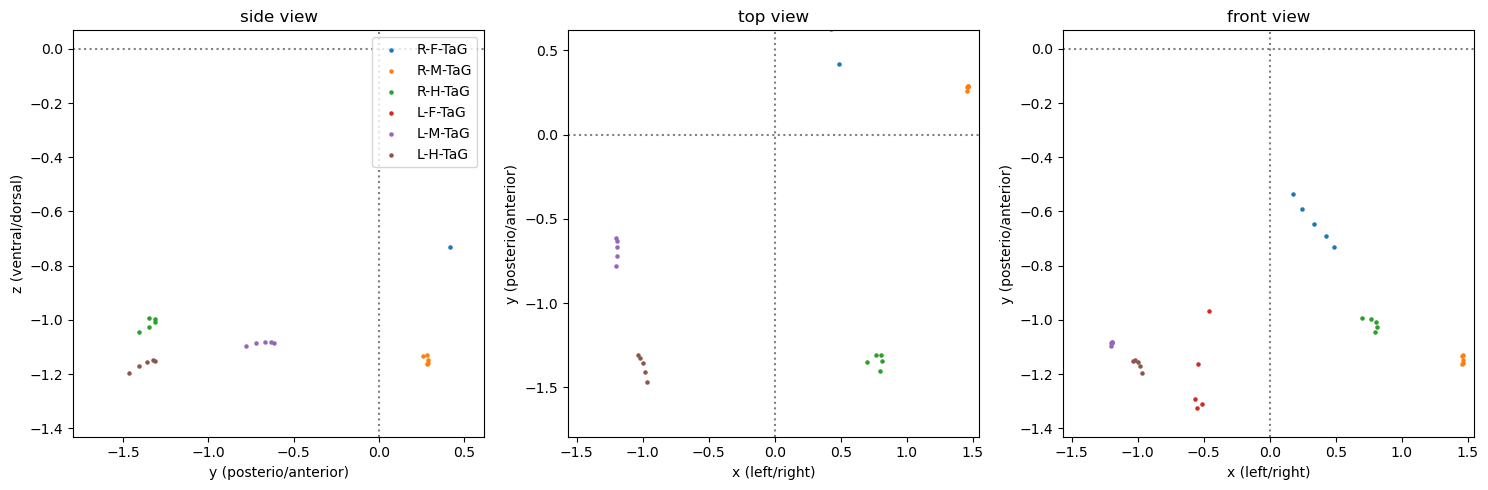

In [325]:
df = data['P9LT'].groupby('flynum').get_group(1)
df = transform_to_flycentric(df)
df = filter_stim(df)
lims = plot_coord_system(df.iloc[:5, :], joints=['TaG'], marker='o', return_lims=True)
for i in range(10):
    plot_coord_system(df.iloc[i:i+5, :], joints=['TaG'], marker='o', return_lims=False, lims=lims, swing=False)

# Plot ball velocity

In [45]:
def get_trajectory(df, rotate_first=False):
    df = df.copy()

    df = df.loc[:, ['x_vel', 'y_vel', 'z_vel']]

    x, y, d = 0, 0, 0
    xs, ys, ds = [], [], []
    for xi, yi, di in df.values:

        if rotate_first:
            d += di

        x += np.cos(d) * xi + np.cos(d - np.pi/2) * -yi
        y += np.sin(d) * xi + np.sin(d - np.pi/2) * -yi
        
        if not rotate_first:
            d += di

        xs.append(x)
        ys.append(y)
        ds.append(d)
        
    xs = np.array(xs)
    ys = np.array(ys)
    ds = np.array(ds)

    return xs, ys, ds

def add_traj(df):
    df = df.copy()
    x, y, d = get_trajectory(df, rotate_first=False)
    df.loc[:, 'x_traj'] = x
    df.loc[:, 'y_traj'] = y
    df.loc[:, 'z_traj'] = d
    return df


def plot_vel_traj(df, title, return_lims=False, lims=(), path=''):
    fig, axmat = plt.subplots(nrows=3, ncols=2, figsize=(10, 5))
    fig.suptitle(title)


    gs = axmat[0, 1].get_gridspec()

    for ax in axmat[:, -1]:
        ax.remove()

    ax = fig.add_subplot(gs[0:, -1])
    axarr = [ax for ax in axmat[:, 0]] + [ax]

    for ax, xyz in zip(axarr, 'xyz'):

        ds = df.loc[:, '{}_vel'.format(xyz)]
        x = ds.index % 1400
        y = ds.values
        ax.plot(x, y)
        ax.set_title('ball velocity {}'.format(xyz))

    for ax in axarr[:2]:
        ax.set_ylabel('vel [mm/s]')
    ax = axarr[2]
    ax.set_ylabel('vel [rad/s]')
    ax.set_xlabel('frame')



    ax = axarr[-1]


    x = df.loc[:, 'x_traj'].values / 200
    y = df.loc[:, 'y_traj'].values / 200
    d = df.loc[:, 'z_traj'].values
    c = df.loc[:, 'z_vel'].values

    vmax = np.max(np.abs(c))
    if lims:
        norm = lims[2]
    else:
        norm = mpl.colors.Normalize(vmin=-vmax, vmax=vmax)

    ax.axhline(0, c='gray', ls=':', zorder=-99)
    ax.axvline(0, c='gray', ls=':', zorder=-99)
    ax.quiver(x, y, np.cos(d), np.sin(d), c, cmap='coolwarm_r', norm=norm)

    ax.set_xlabel('x [mm]')
    ax.set_ylabel('y [mm]')
    ax.set_title('trajectory')

    if lims:
        for ax, x, y in zip(axarr, lims[0], lims[1]):
            ax.set_xlim(x)
            ax.set_ylim(y)

    fig.tight_layout()

    if return_lims:
        xlims = [ ax.get_xlim() for ax in axarr ]
        ylims = [ ax.get_ylim() for ax in axarr ]
        plt.close(fig)
        return xlims, ylims, norm
    
    if path:
        fig.savefig(path)
        plt.close(fig)

gen, fly, trl = 'P9LT', 1, 10
gen, fly, trl = 'P9RT', 1, 1

title = '{} | fly {} | trial {}'.format(gen, fly, trl)
df = data[gen]
df = df.groupby('flynum').get_group(fly).groupby('tnum').get_group(trl)
df = add_traj(df)
plot_vel_traj(df , title, path='./plots/rt_trj.png')




# goal
- understand what drives turning


# Plot stepcylce predictions

In [11]:
# from add_ball import add_ball
# ball_centers = utl.load_ball_centers('config.yml')

# for k, v in ball_centers.items():
#     folder = Path(r'data\Ballsystem_LegKinematics_DataStructures\P9_BPN\VMD_Mov\{}_N1'.format(k))
#     for xyz in folder.glob('*.xyz'):
#         add_ball(xyz, *v, 10)


In [111]:
# centers of the ball for each df in dfs
ball_centers = utl.load_ball_centers('config.yml')
utl.add_distance(data, ball_centers)

INFO: setting ball center for BPN from file BPN_V6_BallCenter.csv
      x = 0.145, y = 4.302, z = 98.967
INFO: setting ball center for P9RT from file P9RT_V6_BallCenter.csv
      x = -0.058, y = 4.081, z = 90.641
INFO: setting ball center for P9LT from file P9LT_V6_BallCenter.csv
      x = -0.036, y = 3.836, z = 90.634
INFO: Adding distance columns for BPN
INFO: Adding distance columns for P9RT
INFO: Adding distance columns for P9LT


## all trials

In [ ]:
def plot_all_tag_r(df_fly, path=''):

    # get TaG distance columns
    cols = [c for c in df.columns if c.endswith('TaG_r')]

    # create figure with # legs x # trials axis grid
    nlegs = len(cols)
    ntrl = len(df_fly.loc[:, 'tnum'].unique())
    fig, axmat = plt.subplots(nrows=nlegs, ncols=ntrl, figsize=(3*ntrl, 2*nlegs))

    # cycle through trials
    for i, (t, df_t) in enumerate(df_fly.groupby('tnum')):
        # cycle through legs
        for j, c in enumerate(cols):
            
            r = df_t.loc[:, c].values # distance
            f = df_t.loc[:, 'fnum'].values % 1400 # frame number
            s = df_t.loc[:, '{}_stepcycle'.format(c[:3]) ].values # stepcyle pred

            # select axis
            ax = axmat[j, i]

            # plot scatter
            ax.scatter(f[s], r[s], s=1, label='off')
            ax.scatter(f[~s], r[~s], s=1, label='on')

            # plot line
            ax.plot(f, r, lw=0.5, c='gray')

            # formatting
            ax.set_title('{} | trl {}'.format(c, t))

    # remove x axis except last row
    for ax in axmat[:-1].flatten():
        ax.set_xticklabels([])
        ax.set_xlabel('')

    fig.tight_layout()

    # save and do not display
    if path:
        fig.savefig(path)
        plt.close(fig)


# df = data['P9LT']
# df = df.groupby('flynum').get_group(1)
# # select only stim frames
# # df = df.loc[ (df.loc[:, 'fnum'] % 1400 >= 400) & (df.loc[:, 'fnum'] % 1400 < 1000) ]
# plot_all_tag_r(df,)


for gen, df_gen in data.items():
    for flynum, df in df_gen.groupby('flynum'):
        p = Path('plots/stepcycles_predictions/{}/flynum{}'.format(gen, flynum))
        # p = Path('plots/stepcycles_predictions_OnlyLightON/{}/flynum{}'.format(gen, flynum))
        plot_all_tag_r(df, path=p)

## individual

In [21]:
def plot_ind_tag_r(df, xlim=(None, None), ylim=(None, None), frames=(), path=''):

    if frames:
        f_0, f_f = frames
        df = df.loc[ ((df.loc[:, 'fnum'] % 1400) >= f_0) & ((df.loc[:, 'fnum'] % 1400) < f_f) ]

    cols = [ c for c in df.columns if 'TaG_r' in c ]

    
    # fig, axmat = plt.subplots(nrows=3, ncols=2, figsize=(12, 7.5))
    fig, axmat = plt.subplots(nrows=3, ncols=2, figsize=(20, 8))

    for c, ax in zip(cols, axmat.T.flatten()):


        r = df.loc[:, c].values # distance
        f = df.loc[:, 'fnum'].values % 1400 # frame number
        s = df.loc[:, '{}_stepcycle'.format(c[:3]) ].values # stepcyle pred


        # plot scatter
        ax.scatter(f[s], r[s], s=1, label='on')
        ax.scatter(f[~s], r[~s], s=1, label='off')

        # plot line
        ax.plot(f, r, lw=0.5, c='gray')

        ax.set_title(c)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    ax = axmat[0][1]
    ax.legend(loc='upper right')

    for ax in axmat[:-1].flatten():
        ax.set_xticklabels('')
    for ax in axmat[-1,:].flatten():
        ax.set_xlabel('frame')

    for ax in axmat[:,0].flatten():
        ax.set_ylabel('r [mm]')

    fig.tight_layout()

    if path:
        fig.savefig(path)
        plt.close(fig)

df = data['P9LT']
df = df.groupby('flynum').get_group(1).groupby('tnum').get_group(10)
plot_ind_tag_r(df, xlim=(0, 1400), ylim=(2.75, 4.25), frames=(0, 1400), path='./plots/radius.svg')
# for f in range(300, 700):
#     plot_ind_tag_r(df, xlim=(300, 700), ylim=(2.75, 4.25), frames=(300, f), path='./plots/radius_movie/r_{0:05d}.png'.format(f))

# generate step features

In [22]:
def add_step_features(df):
    
    df = df.copy()

    cols = [c for c in df.columns if c.endswith('_stepcycle')]
    d = df.loc[:, cols].astype(int).apply(np.diff, axis=0)

    cols_td = [ '{}_stepTD'.format(c.split('_')[0]) for c in cols]
    df.loc[df.index[:-1], cols_td] = (d == +1).values

    cols_lo = [ '{}_stepLO'.format(c.split('_')[0]) for c in cols]
    df.loc[df.index[:-1], cols_lo] = (d == -1).values

    cols = [ c for c in df.columns if c.endswith('_stepTD') ]

    for c in cols:

        leg = c.split('_')[0]
        
        c_cyc = '{}_stepcycle'.format(leg)

        c_dur = '{}_stepPERIOD'.format(leg)
        c_freq = '{}_stepFREQ'.format(leg)
        c_swi = '{}_stepSWING'.format(leg)
        c_sta = '{}_stepSTANCE'.format(leg)
        c_dut = '{}_stepDUTY'.format(leg)

        c_len = '{}_stepLEN'.format(leg)

        cols_xyz = [ '{}-TaG_{}'.format(leg, i) for i in 'xyz' ]

        ds = df.loc[:, c].dropna().astype(bool)
        ds_split = np.split(ds, np.flatnonzero(ds))

        for ds_step in ds_split:

            n_frames = len(ds_step)
            df.loc[ds_step.index, c_dur] = n_frames
            df.loc[ds_step.index, c_freq] = 1 / n_frames

            cyc = df.loc[ds_step.index, c_cyc]

            n_sta = cyc.sum()
            n_swi = (~cyc).sum()
            df.loc[ds_step.index, c_sta] = n_sta
            df.loc[ds_step.index, c_swi] = n_swi
            df.loc[ds_step.index, c_dut] = n_swi / n_sta

            i_on = np.flatnonzero(cyc)
            if len(i_on):
                i_0, i_f = i_on[0], i_on[-1]
                idx_0, idx_f = cyc.index[i_0], cyc.index[i_f]
                xyz_0, xyz_f = df.loc[idx_0, cols_xyz].values, df.loc[idx_f, cols_xyz].values
                xyz = np.linalg.norm(xyz_f - xyz_0)
                df.loc[ds_step.index, c_len] = xyz


            # i_0, i_f = ds_step.index[0], ds_step.index[-1]
            # xyz_0, xyz = df.loc[i_0, cols_xyz], df.loc[i_f, cols_xyz]



    return df

ball_centers = utl.load_ball_centers('config.yml')
utl.add_distance(data, ball_centers)

INFO: setting ball center for BPN from file BPN_V6_BallCenter.csv
      x = 0.145, y = 4.302, z = 98.967
INFO: setting ball center for P9RT from file P9RT_V6_BallCenter.csv
      x = -0.058, y = 4.081, z = 90.641
INFO: setting ball center for P9LT from file P9LT_V6_BallCenter.csv
      x = -0.036, y = 3.836, z = 90.634
INFO: Adding distance columns for BPN
INFO: Adding distance columns for P9RT
INFO: Adding distance columns for P9LT


C:\Users\spillern\AppData\Local\Temp\ipykernel_33580\3806607285.py:47: RuntimeWarning: divide by zero encountered in longlong_scalars
  df.loc[ds_step.index, c_dut] = n_swi / n_sta


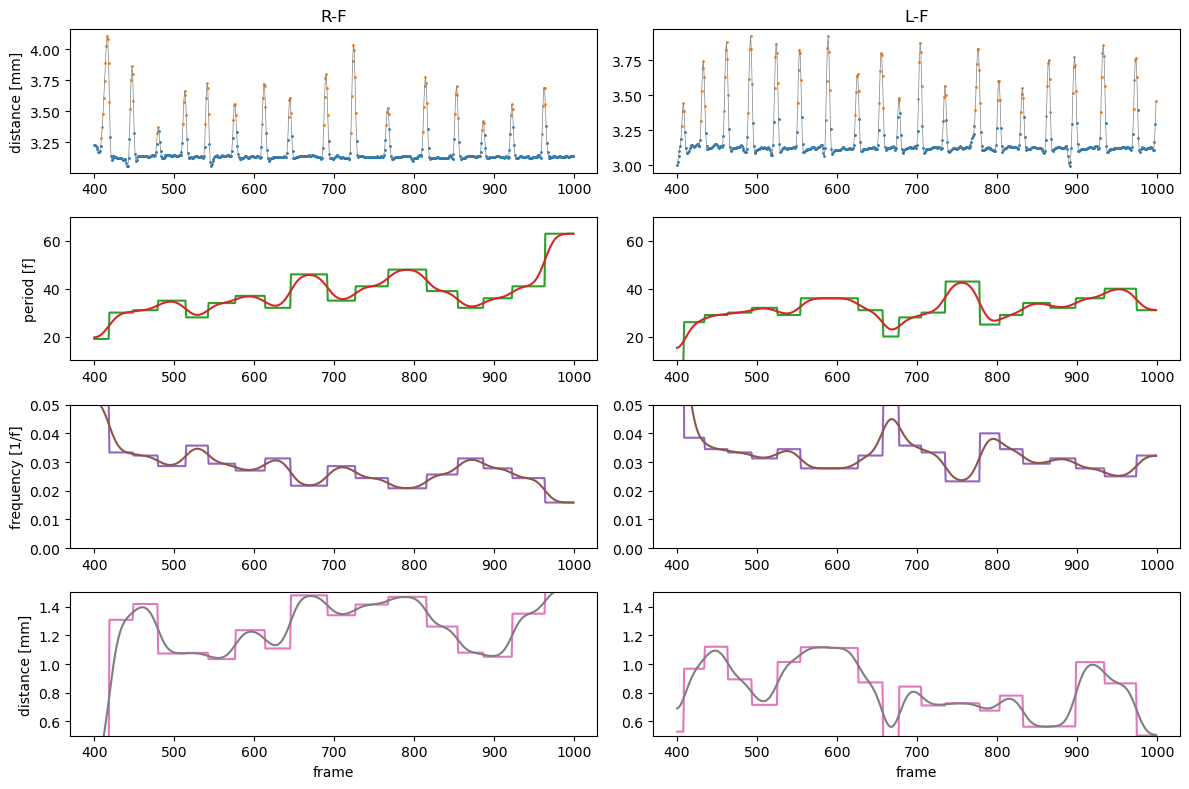

In [26]:
df = data['P9LT'].groupby('flynum').get_group(1)
df = filter_stim(df)
df = add_step_features(df)
df = df.groupby('tnum').get_group(1)

# legs = ['R-F', 'R-M', 'R-H', 'L-F', 'L-M', 'L-H']
legs = ['R-F', 'L-F']

fig, axmat = plt.subplots(nrows=4, ncols=2, figsize=(12, 8))

for axarr, leg in zip(axmat.T, legs):

    f = df.loc[:, 'fnum'].values % 1400 # frame number
    s = df.loc[:, '{}_stepcycle'.format(leg) ].values # stepcyle pred

    ax = axarr[0]
    r = df.loc[:, '{}-TaG_r'.format(leg)].values # distance
    ax.scatter(f[s], r[s], s=1, label='on')
    ax.scatter(f[~s], r[~s], s=1, label='off')
    ax.plot(f, r, lw=0.5, c='gray')

    ax = axarr[1]
    s_dur = df.loc[:, '{}_stepPERIOD'.format(leg) ].values # stepcyle pred
    ax.plot(f, s_dur, c='C2')
    ax.plot(f, gaussian_filter1d(s_dur, 10), c='C3')
    ax.set_ylim(10, 70)

    ax = axarr[2]
    s_dur = df.loc[:, '{}_stepFREQ'.format(leg) ].values # stepcyle pred
    ax.plot(f, s_dur, c='C4')
    ax.plot(f, gaussian_filter1d(s_dur, 10), c='C5')
    ax.set_ylim(0, .05)

    ax = axarr[3]
    s_dur = df.loc[:, '{}_stepLEN'.format(leg) ].values # stepcyle pred
    ax.plot(f, s_dur, c='C6')
    ax.plot(f, gaussian_filter1d(s_dur, 10), c='C7')
    ax.set_ylim(.5, 1.5)

for ax, leg in zip(axmat[0, :], legs):
    ax.set_title(leg)

for ax, leg in zip(axmat[-1, :], legs):
    ax.set_xlabel('frame')

for ax, l in zip(axmat[:, 0], ['distance [mm]', 'period [f]', 'frequency [1/f]', 'distance [mm]']):
    ax.set_ylabel(l)


fig.tight_layout()

fig.savefig('./plots/time.svg')

C:\Users\spillern\AppData\Local\Temp\ipykernel_33580\3806607285.py:47: RuntimeWarning: divide by zero encountered in longlong_scalars
  df.loc[ds_step.index, c_dut] = n_swi / n_sta


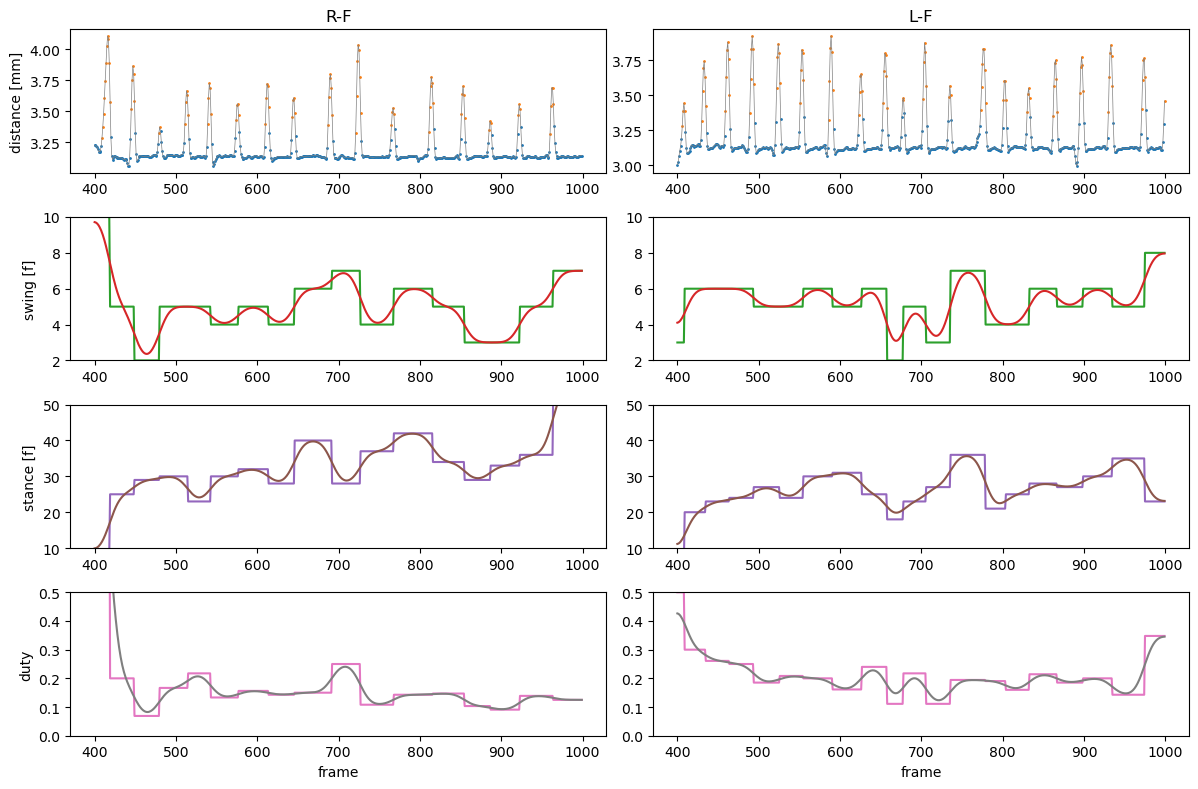

In [117]:
df = data['P9LT'].groupby('flynum').get_group(1)
df = filter_stim(df)
df = add_step_features(df)
df = df.groupby('tnum').get_group(1)

# legs = ['R-F', 'R-M', 'R-H', 'L-F', 'L-M', 'L-H']
legs = ['R-F', 'L-F']

fig, axmat = plt.subplots(nrows=4, ncols=2, figsize=(12, 8))

for axarr, leg in zip(axmat.T, legs):

    f = df.loc[:, 'fnum'].values % 1400 # frame number
    s = df.loc[:, '{}_stepcycle'.format(leg) ].values # stepcyle pred

    ax = axarr[0]
    r = df.loc[:, '{}-TaG_r'.format(leg)].values # distance
    ax.scatter(f[s], r[s], s=1, label='on')
    ax.scatter(f[~s], r[~s], s=1, label='off')
    ax.plot(f, r, lw=0.5, c='gray')

    ax = axarr[1]
    s_dur = df.loc[:, '{}_stepSWING'.format(leg) ].values # stepcyle pred
    ax.plot(f, s_dur, c='C2')
    ax.plot(f, gaussian_filter1d(s_dur, 10), c='C3')
    ax.set_ylim(2, 10)

    ax = axarr[2]
    s_dur = df.loc[:, '{}_stepSTANCE'.format(leg) ].values # stepcyle pred
    ax.plot(f, s_dur, c='C4')
    ax.plot(f, gaussian_filter1d(s_dur, 10), c='C5')
    ax.set_ylim(10, 50)

    ax = axarr[3]
    s_dur = df.loc[:, '{}_stepDUTY'.format(leg) ].values # stepcyle pred
    ax.plot(f, s_dur, c='C6')
    ax.plot(f, gaussian_filter1d(s_dur, 10), c='C7')
    ax.set_ylim(0, .5)

for ax, leg in zip(axmat[0, :], legs):
    ax.set_title(leg)

for ax, leg in zip(axmat[-1, :], legs):
    ax.set_xlabel('frame')

for ax, l in zip(axmat[:, 0], ['distance [mm]', 'swing [f]', 'stance [f]', 'duty']):
    ax.set_ylabel(l)


fig.tight_layout()

fig.savefig('./plots/time2.svg')

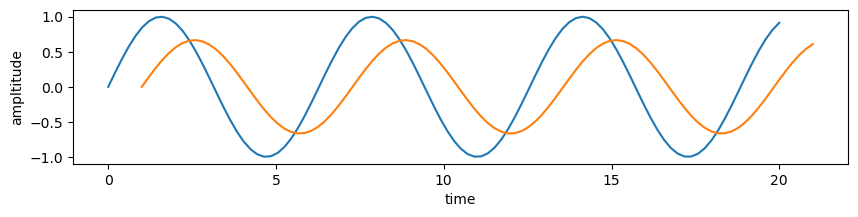

In [35]:
fig, ax = plt.subplots(figsize=(10, 2))
x = np.linspace(0, 20, 100)
y = np.sin(x)
ax.plot(x, y)
ax.plot(x+1, y/1.5)
ax.set_xlabel('time')
ax.set_ylabel('ampltitude')
fig.savefig('./plots/sin.svg')

# fit

In [87]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from scipy.ndimage import uniform_filter1d

lr_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('mod', LinearRegression())
])

In [64]:
df = data['P9LT'].groupby('flynum').get_group(1)
df = filter_stim(df)
df = add_step_features(df)
df

C:\Users\spillern\AppData\Local\Temp\ipykernel_33580\3806607285.py:47: RuntimeWarning: divide by zero encountered in longlong_scalars
  df.loc[ds_step.index, c_dut] = n_swi / n_sta


,flynum,tnum,fnum,SF,R-F-ThC_x,R-F-ThC_y,R-F-ThC_z,R-F-CTr_x,R-F-CTr_y,R-F-CTr_z,...,R-M_stepSTANCE,R-M_stepSWING,R-M_stepDUTY,R-M_stepLEN,R-H_stepPERIOD,R-H_stepFREQ,R-H_stepSTANCE,R-H_stepSWING,R-H_stepDUTY,R-H_stepLEN
400,1,1,400,50,0.444341,-0.065680,90.159048,0.190859,0.205022,90.237229,...,0.0,7.0,inf,NaN,37.0,0.027027,35.0,2.0,0.057143,1.851180
401,1,1,401,50,0.443947,-0.065389,90.158959,0.185279,0.200655,90.237379,...,0.0,7.0,inf,NaN,37.0,0.027027,35.0,2.0,0.057143,1.851180
402,1,1,402,50,0.442756,-0.064710,90.159215,0.181042,0.196372,90.244408,...,0.0,7.0,inf,NaN,37.0,0.027027,35.0,2.0,0.057143,1.851180
403,1,1,403,50,0.441328,-0.063860,90.159590,0.185801,0.198830,90.259020,...,0.0,7.0,inf,NaN,37.0,0.027027,35.0,2.0,0.057143,1.851180
404,1,1,404,50,0.440462,-0.063255,90.160112,0.205138,0.210367,90.278051,...,0.0,7.0,inf,NaN,37.0,0.027027,35.0,2.0,0.057143,1.851180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13595,1,10,13595,50,0.444685,-0.067936,90.160790,0.308795,0.282365,90.208184,...,13.0,1.0,0.076923,0.166821,23.0,0.043478,22.0,1.0,0.045455,1.230249
13596,1,10,13596,50,0.445204,-0.067585,90.161409,0.302662,0.280050,90.208709,...,13.0,1.0,0.076923,0.166821,23.0,0.043478,22.0,1.0,0.045455,1.230249
13597,1,10,13597,50,0.445866,-0.067522,90.161975,0.298021,0.277805,90.208948,...,13.0,1.0,0.076923,0.166821,23.0,0.043478,22.0,1.0,0.045455,1.230249
13598,1,10,13598,50,0.446339,-0.067764,90.162499,0.294074,0.275659,90.208774,...,13.0,1.0,0.076923,0.166821,23.0,0.043478,22.0,1.0,0.045455,1.230249


In [90]:
X.shape

(593, 18)

In [120]:
df = data['P9LT'].groupby('flynum').get_group(1)
df = transform_to_flycentric(df)
df = filter_stim(df)
df = add_step_features(df)
df = df.dropna(axis=0)
df_train = df.groupby('tnum').get_group(1)

df = data['P9RT'].groupby('flynum').get_group(1)
df = transform_to_flycentric(df)
df = filter_stim(df)
df = add_step_features(df)
df = df.dropna(axis=0)
df_test = df.groupby('tnum').get_group(2)

cols_feat = [ c for c in df.columns if c.split('step')[-1] in ['PERIOD', 'FREQ', 'LEN', 'SWING', 'STANCE']]
# cols_feat = [ c for c in df.columns if c[-1] in 'xyz' ]
cols_targ = ['{}_vel'.format(i) for i in 'xyz']


Y = df_train.loc[:, cols_targ]
X = np.hstack([df_train.loc[:, cols_feat]])
X = uniform_filter1d(X, 10, axis=0)
reg = LinearRegression().fit(X, Y)
Y_pred = reg.predict(X)

Y_test = df_test.loc[:, cols_targ]
X_test = np.hstack([df_test.loc[:, cols_feat]])
X_test = uniform_filter1d(X_test, 10, axis=0)
Y_test_pred = reg.predict(X_test)


INFO: Fitted plane through ThC points
      a = -0.21, b = -9.32, c = 89.66, residual = 297.2


C:\Users\spillern\AppData\Local\Temp\ipykernel_33580\3806607285.py:47: RuntimeWarning: divide by zero encountered in longlong_scalars
  df.loc[ds_step.index, c_dut] = n_swi / n_sta


INFO: Fitted plane through ThC points
      a = 0.43, b = -14.01, c = 89.22, residual = 2762.8


0.8702335791917332 -21.912323089189538


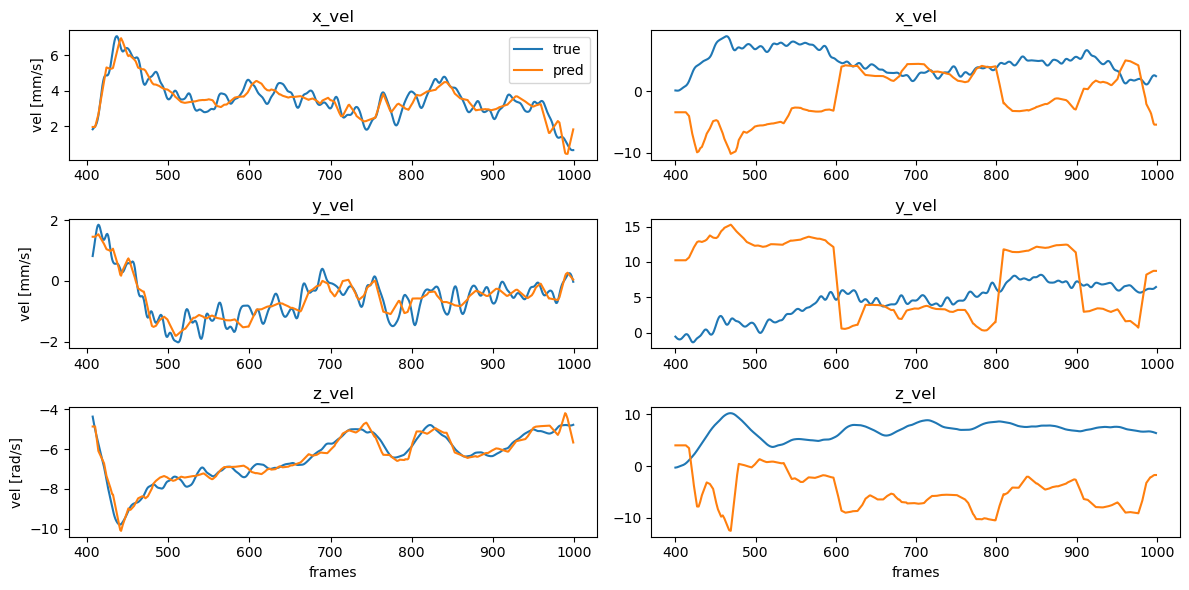

In [121]:

print(reg.score(X, Y), reg.score(X_test, Y_test))
fig, axmat = plt.subplots(nrows=3, ncols=2, figsize=(12, 6))

for i in range(3):
    ax = axmat[i, 0]
    ds = Y.loc[:, cols_targ[i]]
    x = ds.index % 1400
    y = ds.values

    ax.plot(x, y, label='true')
    y = Y_pred[:, i]
    ax.plot(x, y, label='pred')
    ax.set_title(cols_targ[i])
    
    ax = axmat[i, 1]

    ds = Y_test.loc[:, cols_targ[i]]
    x = ds.index % 1400
    y = ds.values

    ax.plot(x, y, label='true')
    y = Y_test_pred[:, i]
    ax.plot(x, y, label='pred')
    ax.set_title(cols_targ[i])

for ax in axmat[-1]:
    ax.set_xlabel('frames')
for ax in axmat[:2, 0]:
    ax.set_ylabel('vel [mm/s]')
ax = axmat[0, 0]
ax.legend()
ax = axmat[2, 0]
ax.set_ylabel('vel [rad/s]')

fig.tight_layout()
# fig.savefig('./plots/reg_rl.svg')

# Filter trials

In [ ]:
bad_trials = {
    'P9RT' : {
        1: [2, 3],
        9: [1, 2, 3],
    },
    'P9LT' : {
        3 : [3, 9],
        9 : [1, 10],
    },
    'BPN' : {
        13 : [1, 2, 3, 4, 9],
    }
}

# OLD

In [47]:
# select one dataset
neuron = 2 # 0: BPN, 1: P9 right, 2: P9 left

# set df and ball center
df = dfs.loc[neuron, 'flydata']
ball_c = l_ball_c[neuron]

# some sets of columns
c_xyz = [c for c in df.columns if c[-2:] in ['_x', '_y', '_z']]
c_tag = [ c for c in c_xyz if 'TaG_' in c ]
c_ball = [ 'x_vel', 'y_vel', 'z_vel' ]


# TODO fix mapping in raw data
# leg2step = {
#     'R-F': 'R1',
#     'R-M': 'R2', 
#     'R-H': 'R3',
#     'L-F': 'L1',
#     'L-M': 'L2', 
#     'L-H': 'L3',}

leg2step = { # TODO workaround
    'R-F': 'L1',
    'R-M': 'L2', 
    'R-H': 'L3',
    'L-F': 'R1',
    'L-M': 'R2', 
    'L-H': 'R3',}

# raw joint positions
df_raw = df
df_raw

# distances for joints from center of ball
df_d = utl.dist_from_center(df_raw, ball_c)
df_d

df_raw

,flynum,tnum,fnum,SF,R-F-ThC_x,R-F-ThC_y,R-F-ThC_z,R-F-CTr_x,R-F-CTr_y,R-F-CTr_z,...,R3D_flex,x_vel,y_vel,z_vel,L1_stepcycle,L2_stepcycle,L3_stepcycle,R1_stepcycle,R2_stepcycle,R3_stepcycle
0,1,1,0,25,0.512781,-0.059520,90.129425,0.360708,0.300253,90.263167,...,152.890039,-0.484678,4.796274e-28,5.826226,True,True,True,True,True,True
1,1,1,1,25,0.512328,-0.058908,90.128075,0.365145,0.298875,90.273223,...,152.549858,0.482418,1.678248e+00,5.630400,True,True,True,True,True,True
2,1,1,2,25,0.510884,-0.058121,90.127967,0.368342,0.298071,90.282739,...,150.999794,1.118539,2.778597e+00,5.430381,True,True,True,True,True,True
3,1,1,3,25,0.508436,-0.057045,90.128902,0.371228,0.298778,90.290147,...,149.650744,1.298492,3.056724e+00,5.219781,True,True,True,True,True,True
4,1,1,4,25,0.505209,-0.055487,90.130446,0.372456,0.301202,90.296125,...,149.566883,1.246395,2.722456e+00,4.982370,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181995,13,10,13995,100,0.830110,-0.081763,90.068229,0.759043,0.324531,90.117033,...,171.880922,-0.800989,1.170721e+00,0.761779,True,True,True,True,True,True
181996,13,10,13996,100,0.830633,-0.082386,90.068170,0.756384,0.322681,90.117266,...,171.945424,-1.211456,1.696038e+00,0.513978,True,True,True,True,True,True
181997,13,10,13997,100,0.831315,-0.083065,90.068013,0.754366,0.320797,90.117446,...,171.890850,-1.482893,2.466001e+00,0.108765,True,True,True,True,True,True
181998,13,10,13998,100,0.832071,-0.083755,90.067785,0.752900,0.318976,90.117516,...,171.828323,-1.728447,3.277642e+00,-0.323407,True,True,True,True,True,True


# Plot stepcycles

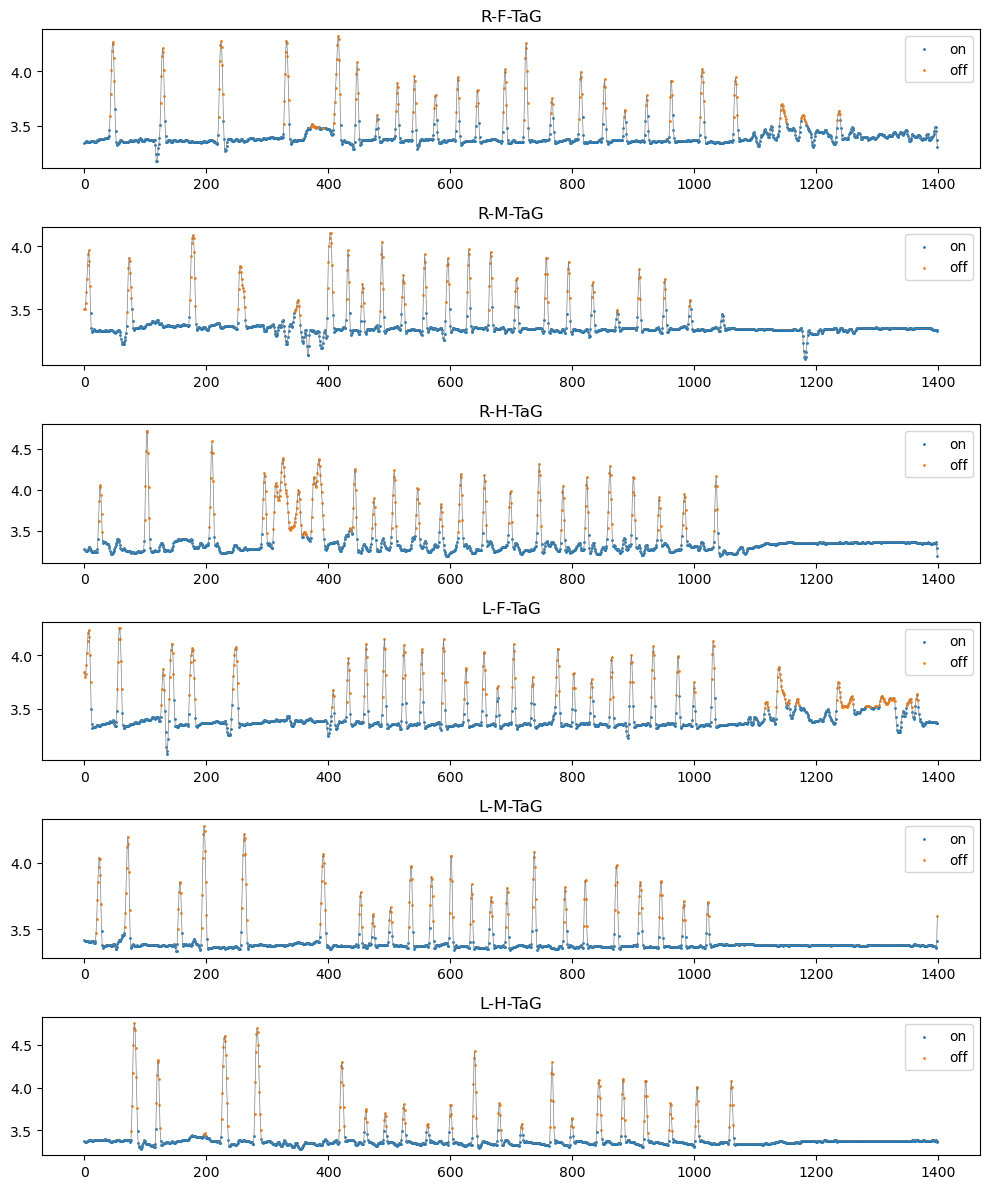

In [39]:
def plot_tag(df_raw, df_d, flynum, tnum, xlim=(None, None), ylim=(None, None), frames=(None, None), close_fig=False, path=''):

    df1 = df_raw.groupby('flynum').get_group(flynum)
    df1 = df1.groupby('tnum').get_group(tnum) # comment this line to look at all trials
    df2 = df_d.loc[df1.index, :]

    cols = [ c for c in df2.columns if 'TaG' in c ]

    n = len(cols)
    fig, axarr = plt.subplots(nrows=n, figsize=(10, 2*n))
    first_frame, last_frame = frames

    for c, ax in zip(cols, axarr):

        r = df2.loc[first_frame:last_frame, c]
        ax.plot(r, lw=0.5, c='gray')

        c_on = '{}_stepcycle'.format(leg2step[c[:3]])
        f_on = df1.loc[first_frame:last_frame, c_on]

        x = r.loc[f_on]
        ax.scatter(x.index, x.values, s=1, label='on')

        x = r.loc[~f_on]
        ax.scatter(x.index, x.values, s=1, label='off')

        ax.legend(loc='upper right')
        ax.set_title(c)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)


    fig.tight_layout()

    if path:
        fig.savefig(path)

    if close_fig:
        plt.close(fig)

flynum, tnum = 1, 1
plot_tag(df_raw, df_d, flynum, tnum, xlim=(None, None))

In [ ]:
# TODO distribution

# Trajectory

In [27]:
def get_trajectory(df, rotate_first=False):

    df = df.loc[:, ['x_vel', 'y_vel', 'z_vel']]

    x, y, d = 0, 0, 0
    xs, ys, ds = [], [], []
    for xi, yi, di in df.values:

        if rotate_first:
            d += di

        x += np.cos(d) * xi + np.cos(d - np.pi/2) * -yi
        y += np.sin(d) * xi + np.sin(d - np.pi/2) * -yi
        
        if not rotate_first:
            d += di

        xs.append(x)
        ys.append(y)
        ds.append(d)
        
    xs = np.array(xs)
    ys = np.array(ys)
    ds = np.array(ds)

    return xs, ys, ds

# df = df_raw.groupby(['flynum', 'tnum']).get_group((1, 1)).loc[400:1000, :]
# x, y, d = get_trajectory(df)

Text(0, 0.5, 'y')

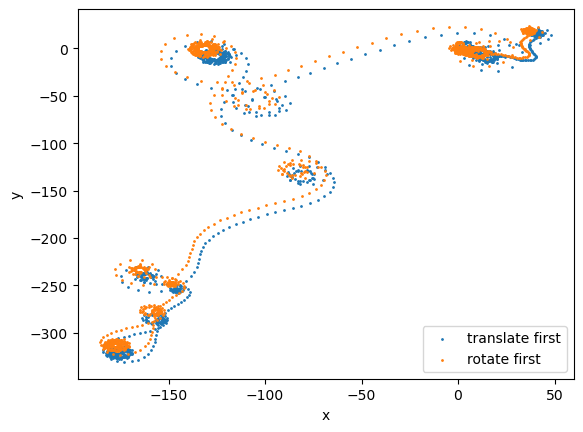

In [206]:
df = df_raw.groupby(['flynum', 'tnum']).get_group((1, 1)) #.loc[400:1000, :]

fig, ax = plt.subplots()

x, y, d = get_trajectory(df, rotate_first=False)
ax.scatter(x, y, s=1, label='translate first')

x, y, d = get_trajectory(df, rotate_first=True)
ax.scatter(x, y, s=1, label='rotate first')

ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')

Text(0.5, 1.0, 'trajectory for P9L fly')

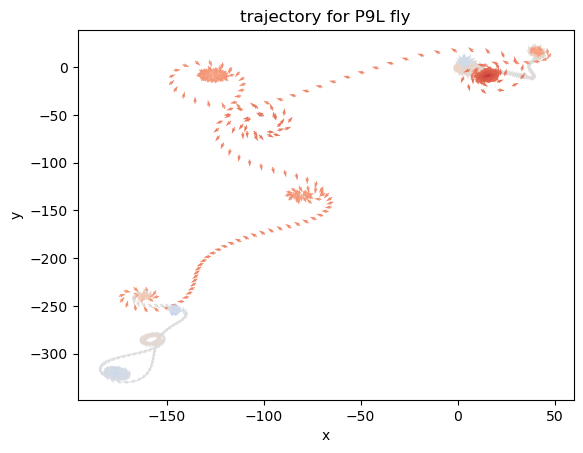

In [204]:
df = df_raw.groupby(['flynum', 'tnum']).get_group((1, 1))
x, y, d = get_trajectory(df, rotate_first=False)
c = df.loc[:, 'z_vel']
vmax = np.max(np.abs(c))
norm = mpl.colors.Normalize(vmin=-vmax, vmax=vmax)

fig, ax = plt.subplots()

ax.quiver(x, y, np.cos(d), np.sin(d), c, cmap='coolwarm', norm=norm)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('trajectory for P9L fly')

# create GIF

In [37]:
import imageio.v2 as imageio
from skimage.transform import rescale
from pathlib import Path
import numpy as np

def write_gif(inps, out, fps=30, force_overwrite=False, delete_inp=True):
    '''Generate GIF from list of files

    Parameters
    ----------
    inps : list
        Files to be concatenated in GIF
    out : path-like
        Name of the output file, has to have .gif suffix
    fps : int, optional
        Frames per second in GIF, by default 2
    force_overwrite : bool, optional
        If True, overwrite output file, by default False
    delete_inp : bool, optional
        If False, keep input files, by default True
    '''

    out = Path(out)
    if out.is_file() and not force_overwrite:
        print('WARNING: exiting because file {} already exists and force_overwrite is {}'.format(out, force_overwrite))
        return

    with imageio.get_writer(out, mode='I', fps=fps) as writer:
        for inp in inps:
            inp = Path(inp)
            img = imageio.imread(inp)
            writer.append_data(img)
            if delete_inp:
                inp.unlink(missing_ok=True)



# frames = (400, 1000) # set range of frames to animate

# l_png = [] # list of png
# for f in np.arange(*frames):

#     png = 'frame{}.png'.format(f)

#     # plot and save file
#     plot_tag(df_raw, df_d, flynum, tnum, xlim=(400, 1000), ylim=(3, 4.2), frames=(frames[0], f), path=png, close_fig=True)
    
#     l_png.append(png) # collect png in list


# write_gif(l_png, 'combined.gif', force_overwrite=True)

In [14]:
def concatenate_images(img1, img2):

    im1 = imageio.imread(img1)[:,:,:3]
    im2 = imageio.imread(img2)[:,:,:3]
    h1, h2 = im1.shape[0], im2.shape[0]
    im2 = rescale(im2, h1 / h2, channel_axis=2, preserve_range=True).astype(int)

    im12 = np.hstack([im1, im2])

    return im12

plots = Path('./plots/radius_movie/').glob('*.png')
ims = []
for im1 in plots:
    n = im1.with_suffix('').name
    f = n.split('_')[-1]
    im2 = Path(r'data\Ballsystem_LegKinematics_DataStructures\P9_BPN\VMD_Mov\P9LTN1_10.{}.bmp'.format(f))

    im = concatenate_images(im1, im2).astype(np.uint8)
    ims.append(im)



In [15]:
with imageio.get_writer('stepcycles.mp4', format='FFMPEG', fps=10) as writer:
    for im in ims:
        writer.append_data(im)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2199, 750) to (2208, 752) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [7]:
ps = Path('./data/Ballsystem_LegKinematics_DataStructures/P9_BPN/VMD_Mov/').glob('ball*.bmp')

with imageio.get_writer('ball_fit.mp4', format='FFMPEG', fps=60) as writer:
    for p in ps:
        im = imageio.imread(p)
        writer.append_data(im)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (712, 612) to (720, 624) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [45]:
ps = Path('./data/Ballsystem_LegKinematics_DataStructures/P9_BPN/VMD_Mov/').glob('ball*.bmp')

with imageio.get_writer('ball_fit2.mp4', format='FFMPEG', fps=60) as writer:
    for p in ps:
        im = imageio.imread(p)
        writer.append_data(im)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (712, 612) to (720, 624) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [44]:
ps = [Path('./data/Ballsystem_LegKinematics_DataStructures/P9_BPN/VMD_Mov/LR_back.00{}.bmp'.format(i)) for i in range(400, 1000) ]

with imageio.get_writer('lr_overlay.mp4', fps=60) as writer:
    for p in ps:
        im = imageio.imread(p)[:,:, :3]
        writer.append_data(im)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1273, 924) to (1280, 928) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


# Plot angle distributions

In [ ]:
col_ang = [c for c in df_raw.columns if c.split('_')[-1] in ['rot', 'flex', 'abduct'] ]

l_df = []
for i, n in enumerate(['BPN', 'P9r', 'P9l']):
    df = dfs.loc[i, 'flydata']
    for c in col_ang:
        x, t = c.split('_')
        l, j = x[:-1], x[-1:]

        d = pd.DataFrame(index=df.index, data={
            'ang': df.loc[:, c],
            'flynum': df.loc[:, 'flynum'],
            'tnum': df.loc[:, 'tnum'],
            'fnum': df.loc[:, 'fnum'],
            'SF': df.loc[:, 'SF'],
            'leg': l,
            'joint': j,
            'type': t,
            'P9': n,
        })
        l_df.append(d)
df = pd.concat(l_df)
df.loc[:, 'stim'] = df.loc[:, 'fnum'].apply(lambda x: (x % 1400 >= 400) & (x % 1400 <= 1000) )
df = df.loc[ df.loc[:, 'stim'] ]
df_ang = df

In [ ]:
for typ in ['flex', 'rot', 'abduct']:
    df = df_ang.groupby('type').get_group(typ)
    # df = df.groupby(['flynum', 'tnum']).get_group((1, 1))
    g = sns.FacetGrid(df, col='joint', row='leg', sharey=False)
    g.map_dataframe(sns.histplot, x='ang', hue='P9', kde=True, stat='density', common_norm=False)
    g.add_legend()
    g.fig.suptitle(typ)
    g.fig.savefig('plots/hist_p9_ang_{}.png'.format(typ))

# Unified coordinate system

In [58]:
n = df_raw.loc[:, ['Notum_x', 'Notum_y', 'Notum_z']].mean().values
c = l_ball_c[1]
z = n
z = z / np.linalg.norm(z)
p = np.array([1, 0, 0])
y = np.cross(z, p)
x = np.cross(z, y)
tm = np.vstack([x, y, z])
tm

array([[-9.99999925e-01, -2.27741734e-06,  2.73434656e-04],
       [-0.00000000e+00,  9.99965279e-01,  8.32863797e-03],
       [ 2.73444151e-04, -8.32863797e-03,  9.99965279e-01]])

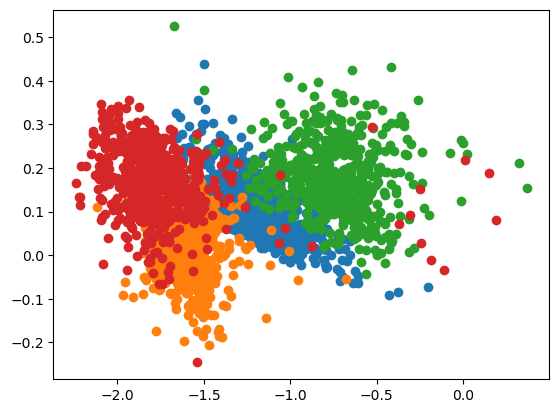

In [104]:
lo = pd.read_csv('./data/Ballsystem_LegKinematics_DataStructures/P9LT_step cycle/L1_LO.csv', header=0, index_col=0).apply(lambda v: (v@tm)[:2], axis=1)
td = pd.read_csv('./data/Ballsystem_LegKinematics_DataStructures/P9LT_step cycle/L1_TD.csv', header=0, index_col=0).apply(lambda v: (v@tm)[:2], axis=1)
lo = np.array([i for i in lo])
td = np.array([i for i in td])

fig, ax = plt.subplots()
# np.arctan2(lo[:,0], lo[:, 1])
ax.scatter(lo[:, 0], lo[:, 1])
ax.scatter(td [:, 0], td [:, 1])

lo = pd.read_csv('./data/Ballsystem_LegKinematics_DataStructures/P9LT_step cycle/R1_LO.csv', header=0, index_col=0).apply(lambda v: (v@tm)[:2], axis=1)
td = pd.read_csv('./data/Ballsystem_LegKinematics_DataStructures/P9LT_step cycle/R1_TD.csv', header=0, index_col=0).apply(lambda v: (v@tm)[:2], axis=1)
lo = np.array([i for i in lo])
td = np.array([i for i in td])

ax.scatter(lo[:, 0], lo[:, 1])
ax.scatter(td [:, 0], td [:, 1])

<AxesSubplot:xlabel='R-F-TaG_x', ylabel='R-F-TaG_z'>

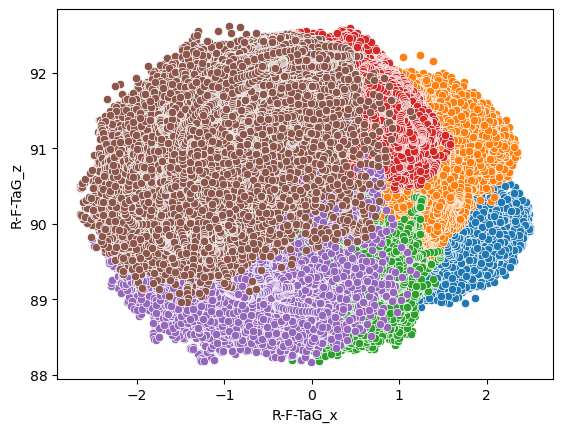

In [17]:
df = df_raw
sns.scatterplot(df, x='R-F-TaG_x', y='R-F-TaG_z')
sns.scatterplot(df, x='L-F-TaG_x', y='L-F-TaG_z')
sns.scatterplot(df, x='R-M-TaG_x', y='R-M-TaG_z')
sns.scatterplot(df, x='L-M-TaG_x', y='L-M-TaG_z')
sns.scatterplot(df, x='R-H-TaG_x', y='R-H-TaG_z')
sns.scatterplot(df, x='L-H-TaG_x', y='L-H-TaG_z')